# Noise Suppression 

In this example, we will try to perform some operations to clean the input signal before performing the voice-activity-detection. The steps to follow:

- 1 Reduce the contribution of the DC offset by applying a DC removal filter.
- 2 Apply a detrenting filter + high-pass filter to reduce the average redisual DC offset
- 3 Apply a noise suppression filter

We will use some of the providing files availables in the IMU-T dataset for testing.

In [1]:
from IPython.display import Audio, display, HTML
from smartmeet.filter.detrend import Detrend
from smartmeet.io.decoder import Decoder
from smartmeet.filter.dc_removal import DCRemoval
from smartmeet.modules.noise_suppression import NoiseSuppressor
from smartmeet.tools.resample import Resample

from librosa.display import waveplot
import matplotlib.pyplot as plt
import numpy as np

File properties: Channels=1, SampleRate=8000 Hz


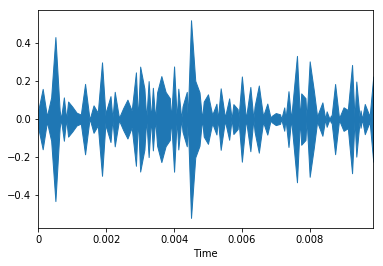

In [2]:
file = "/home/mboujemaoui/Developer/smartmeet-research-python/resources/data/h_noise.wav"
decoder = Decoder(file=file)

time = 0.01 # Read just one second
samples = int(decoder.sample_rate * time)
data = decoder.read(frames_per_channel=samples)

print("File properties: Channels=%s, SampleRate=%s Hz" % (str(decoder.channels), str(decoder.sample_rate)))
Audio(url=file, embed=False)

plt.figure()
waveplot(data, sr=decoder.sample_rate)

DC offset is an offsetting of a signal from zero. The cause is almost always a fixed voltage offset somewhere in the audio chain before the analog signal is converted to digital values.
 
Some of the general problems:

- DC offset will have DC offset when mixed.
- DC offset can cause inaudible low level distortion.
- DC offset will become worse if the recording is amplified.

Sometimes the DC offset is just the average of all the samples, a detrending filter may mitigates those effects easily:

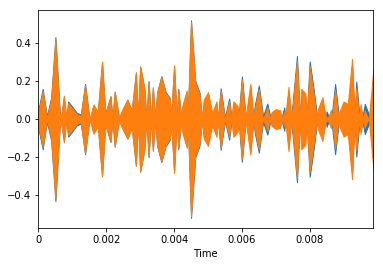

In [3]:
detrend = Detrend(type="linear")
detrend_data = detrend.process(data)

plt.figure()
waveplot(data, sr=decoder.sample_rate)
waveplot(detrend_data, sr=decoder.sample_rate)


The previous step could potentially create a new offset and therefore a click in some rare cases. Two cases are noteworthy:

- Where only part of the audio is offset, for example if absolute silence with no offset has been inserted into an offset recording.
- Where the offset is not constant. Strictly speaking this is not DC offset, it is sub-sonic modulation or "slowly changing DC bias", but over a short time period it looks very much like DC offset.

In those cases an High-Pass DC removal may well remove the residual offset. This is what the DC Removal filter is doing. It implements a Butterworth filter with a cut-off frequency of 10 Hz.


Let's start by loading one file from the database and displayng the original properties.


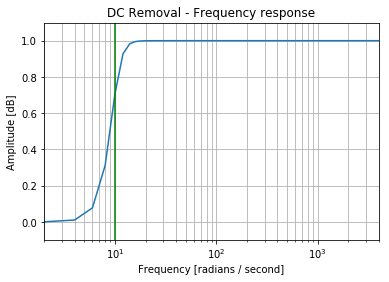

In [4]:
dc_removal = DCRemoval(rate=decoder.sample_rate)

w, h = dc_removal.freqz()
plt.plot(w / np.pi * decoder.sample_rate * 0.5, abs(h))
plt.xscale('log')
plt.title('DC Removal - Frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(dc_removal.cutoff, color='green') # cutoff frequency
plt.show()

Those are the results after filtering the signal:

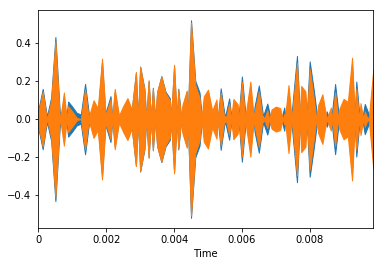

In [5]:
clean_data = dc_removal.process(detrend_data)

plt.figure()
waveplot(data, sr=decoder.sample_rate)
waveplot(clean_data, sr=decoder.sample_rate)

Finally, we can apply the Noise Suppresion algorithm to eliminate any remaining noise:

In [6]:
noise = NoiseSuppressor(rate=decoder.sample_rate, channels=decoder.channels)
out = noise.process(clean_data)
len(str(out))

160
<class 'bytearray'> 160


522

In [7]:
from webrtc_audio_processing import AudioProcessingModule as AP
from smartmeet.utils.converter import Converter

ap = AP(enable_ns=True)
ap.set_ns_level(0)
ap.set_stream_format(decoder.sample_rate, decoder.channels)

fixed = Converter.fromFloatToInt16(clean_data)
print(type(fixed), len(fixed), fixed.dtype, fixed.nbytes)

<class 'numpy.ndarray'> 80 int16 160


In [35]:
serialized = str(fixed.copy().tobytes())
print(len(serialized), type(serialized))

510 <class 'str'>


In [36]:
try:
    output = ap.process_stream(serialized)
except Exception as e:
    print("Error while running. ", e)

In [40]:
result = np.fromstring(output.decode("utf-8", "surrogatepass"), dtype=np.int16)
result = np.reshape(result, (samples))

UnicodeEncodeError: 'utf-8' codec can't encode character '\udcff' in position 4: surrogates not allowed

In [ ]:
ba = bytearray(output)